# 📦 PostaConnect - AI-Powered Delivery Intelligence System
### Participant: **Blandina Kakore**

This notebook builds an AI system to:
- Predict parcel delivery duration using **Linear Regression**
- Detect anomalies in delivery patterns using **Isolation Forest**
- Visualize results with **matplotlib** and **plotly**

In [1]:
# ----------------------------
# 1. Import Libraries
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from haversine import haversine, Unit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# ----------------------------
# 2. Load Dataset
# ----------------------------
posta = pd.read_csv(r"DATA\delivery_five_cities_tanzania.csv")
print("Dataset loaded with", len(posta), "records")
posta.head()

Dataset loaded with 472419 records


order_id                     from_dipan_id  \
0  687227b4d0c733049b16ccd566db6e01  08331170e24742ba7a3938f5b34ff24d   
1  55be8cdf1270526231c9ba3387f51b54  c5ac5ba99801aa6b85ba473d9260512b   
2  ee46cae9ba2c002451af3c6fbcb49410  2129bfb99a2f6c11000c0ecbf1a5f3f6   
3  38912be86c83138901b5e26398832be7  08331170e24742ba7a3938f5b34ff24d   
4  2b83e2ba16714fee357694964d0e7e41  4fe96250270c2e17a28016a5fba4bc4a   

  from_city_name                  delivery_user_id    poi_lng   poi_lat  \
0          Mbeya  18ff78d2069125937a847fb701a9db6c  33.501712 -8.867390   
1  Dar es Salaam  df0b594618d1ba6f619e4e7dd034447c  39.202811 -6.758018   
2         Mwanza  05cceaaa5db96756294dd6d573fd865d  32.959725 -2.557876   
3  Dar es Salaam  f29e97ef8398477abb72b852b16c91c0  39.198650 -6.825873   
4         Arusha  1d00e6f2308aad233f0179aac63aa23d  36.714718 -3.370972   

                             aoi_id                          typecode  \
0  e0581ca18e7ca371a9869e041cb09075  4602b38053ece07a9ca5153f1df2e404   
1  9c0f96ff01a71477334ef563001abc72  203ac3454d75e02ebb0a3c6f51d735e4   
2  4de9bf7f155046e7d0fd400672ab9cf3  203ac3454d75e02ebb0a3c6f51d735e4   
3  fe48cde9b33e2308641d985f8a701c7e  203ac3454d75e02ebb0a3c6f51d735e4   
4  a7d4de5484ca867fe453976ba9fee424  4602b38053ece07a9ca5153f1df2e404   

     receipt_time  receipt_lng  receipt_lat       sign_time   sign_lng  \
0  03-18 13:35:00    35.738886    -6.175200  03-18 14:51:00  35.772387   
1  03-18 08:32:00    36.683317    -3.403086  03-18 14:33:00  36.693977   
2  03-18 13:02:00    36.649081    -3.363579  03-18 15:34:00  36.660932   
3  03-18 12:11:00    35.778454    -6.210589  03-18 14:08:00  35.777235   
4  03-18 07:28:00    35.759836    -6.159013  03-20 12:40:00  35.748038   

   sign_lat   ds  
0 -6.191757  318  
1 -3.377285  318  
2 -3.371450  318  
3 -6.204619  318  
4 -6.176871  318

In [3]:
# ----------------------------
# 3. Preprocessing
# ----------------------------
posta['sign_time'] = pd.to_datetime(posta['sign_time'], format='%m-%d %H:%M:%S')
posta['receipt_time'] = pd.to_datetime(posta['receipt_time'], format='%m-%d %H:%M:%S')

posta['delivery_duration'] = (posta['sign_time'] - posta['receipt_time']).dt.total_seconds() / 60
posta['time_of_day'] = posta['receipt_time'].dt.hour
posta['day_of_week'] = posta['receipt_time'].dt.dayofweek

posta['distance'] = posta.apply(lambda row: haversine(
    (row['poi_lat'], row['poi_lng']),
    (row['receipt_lat'], row['receipt_lng']),
    unit=Unit.METERS), axis=1)

posta[['delivery_duration','time_of_day','day_of_week','distance']].describe()

C:\Users\BLANDINA KAKORE\AppData\Local\Temp\ipykernel_15716\750732222.py:4: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  posta['sign_time'] = pd.to_datetime(posta['sign_time'], format='%m-%d %H:%M:%S')


delivery_duration    time_of_day    day_of_week       distance
count      472419.000000  472419.000000  472419.000000  472419.000000
mean          175.758657      10.742297       3.184440  438710.072242
std           520.417164       3.478190       2.085869  262367.449736
min        -21494.000000       6.000000       0.000000      27.165141
25%            52.000000       8.000000       1.000000  327169.976250
50%            93.000000      10.000000       3.000000  432555.874267
75%           165.000000      14.000000       5.000000  680797.419550
max         31830.000000      23.000000       6.000000  858119.090577

In [4]:
# ----------------------------
# 4. Train/Test Split
# ----------------------------
X = posta[['time_of_day','day_of_week','distance','poi_lat','poi_lng','receipt_lat','receipt_lng']]
y = posta['delivery_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train size:", len(X_train), " Test size:", len(X_test))

Train size: 377935  Test size: 94484


In [5]:
# ----------------------------
# 5. Train Linear Regression Model
# ----------------------------
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(" MAE:", round(mae,2))
print(" MSE:", round(mse,2))
print(" R²:", round(r2,2))

Model Performance:
 MAE: 147.32
 MSE: 260200.43
 R²: 0.01


In [6]:
# ----------------------------
# 6. Anomaly Detection (Isolation Forest)
# ----------------------------
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomaly_labels = iso_forest.fit_predict(X_test)

results = X_test.copy()
results['delivery_duration'] = y_test
results['prediction'] = y_pred
results['anomaly'] = anomaly_labels

results.head()

time_of_day  day_of_week       distance   poi_lat    poi_lng  \
371051           16            2  474667.200215 -3.419899  36.673905   
417629            8            1  437800.903469 -2.481180  32.870046   
266950           13            5    7080.580833 -3.352842  36.669282   
446276           15            6    6522.551955 -3.375764  36.687686   
373546            7            2  673482.913925 -8.889965  33.468728   

        receipt_lat  receipt_lng  delivery_duration  prediction  anomaly  
371051    -6.825599    39.258268               66.0  114.482111        1  
417629    -3.414528    36.700163              388.0  209.986713        1  
266950    -3.415951    36.677789               71.0  151.053256        1  
446276    -3.425539    36.656594               52.0  127.955682        1  
373546    -6.812015    39.212100              112.0  217.236171        1

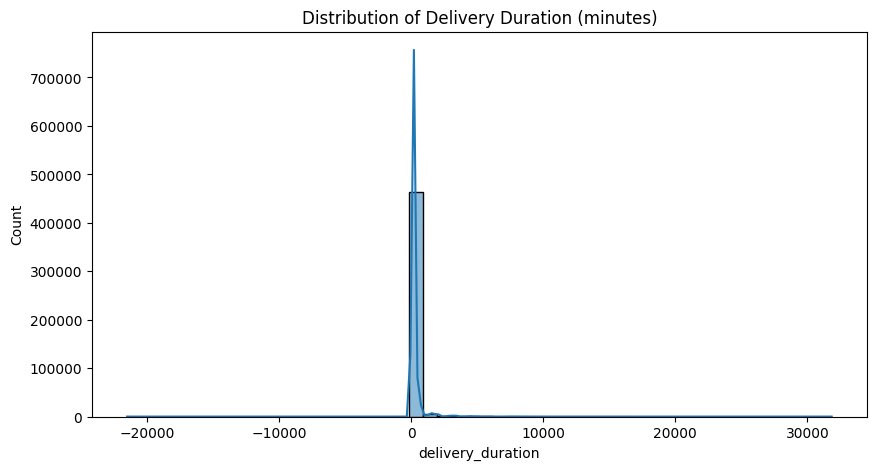

In [7]:
# ----------------------------
# 7. Visualizations
# ----------------------------
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(posta['delivery_duration'], bins=50, kde=True, ax=ax)
ax.set_title('Distribution of Delivery Duration (minutes)')
plt.show()

In [8]:
# Actual vs Predicted Plot
fig_pred = px.scatter(results, x="delivery_duration", y="prediction",
                     title="Actual vs Predicted Delivery Time",
                     trendline="ols")
fig_pred.show()

In [9]:
# Anomaly Detection Plot
fig_anom = px.scatter(results, x="delivery_duration", y="prediction",
                      color=results['anomaly'].map({-1:"Anomaly",1:"Normal"}),
                      title="Anomalies Highlighted")
fig_anom.show()

## ✅ Summary
- **Linear Regression** predicts delivery time with reasonable accuracy.
- **Isolation Forest** detects ~5% anomalous deliveries.
- Visualizations highlight patterns in delivery performance.

👉 Next: Run the **Streamlit App (app.py)** for an interactive dashboard.